In [1]:
import gc 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from typing import Union, List

from multiprocessing import Pool

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

from lightgbm import LGBMClassifier


%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/misha_beliy/opt/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
PATH_TO_DATA_FOLDER = "data/"

# [Optional] Mount google drive for google colab

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

ModuleNotFoundError: No module named 'google'

In [ ]:
PATH_TO_DATA_FOLDER = "drive/MyDrive/4 курс/ML/HW-1/data/"

# My implementation of RandomForestClassifier 

In [3]:
class MyRandomForestClassifier:
    _base_model_class = DecisionTreeClassifier
    
    _default_base_model_params = {
        "criterion": 'gini', 
        "max_depth": None, 
        "min_samples_split": 2, 
        "min_samples_leaf": 1, 
        "min_weight_fraction_leaf": 0.0, 
        "max_features": 'auto', 
        "max_leaf_nodes": None, 
        "min_impurity_decrease": 0.0, 
        "min_impurity_split": None,
    }
    
    def __init__(
        self,
        n_estimators: int = 100,
        bootstrap: bool = True,
        random_state: Union[int, np.random.RandomState] = None,
        max_samples: int = None,
        base_model_params: dict = {},
        threads: int = None,
    ):
        self._n_estimators = n_estimators
        self._bootstrap = bootstrap
        self._random_state = random_state
        self._max_samples = max_samples
        self._base_model_params = {**self._default_base_model_params, **base_model_params}
        self._estimators: List[self._base_model_class] = []
        self._data: pd.DataFrame = None
        self._threads = threads
        
    def fit(self, x: pd.DataFrame, y: pd.Series):
        self._set_random_state()
        data = x.copy()
        data["target"] = y
        self._data = data
        if self._threads:
            with Pool(self._threads) as pool:
                self._estimators = pool.map(self._fit_one, range(self._n_estimators))
        else:
            self._estimators = [self._fit_one(i) for i in range(self._n_estimators)]
    
    def predict(self, x: pd.DataFrame) -> np.array:
        proba = self.predict_proba(x)
        predicted = proba.argmax(axis=1)
        return predicted
        
    
    def predict_proba(self, x: pd.DataFrame) -> np.ndarray:
        probas = self._predict_probas(x)
        proba = 0
        for predicted in probas:
            proba += predicted
        proba /= len(probas)
        return proba
    
    def _predict_probas(self, x: pd.DataFrame) -> list:
        if self._threads:
            with Pool(self._threads) as pool:
                probas = pool.starmap(
                    self._predict_one_proba, 
                    [(i, x) for i in range(self._n_estimators)]
                )
        else:
            probas = [clf.predict_proba(x) for clf in self._estimators]
        
        return probas
    
    def _predict_one_proba(self, i: int, x: pd.DataFrame) -> np.ndarray:
        return self._estimators[i].predict_proba(x)
                        
    def _set_random_state(self) -> None:
        if self._random_state is None:
            return
        if isinstance(self._random_state, int):
            np.random.seed(self._random_state)
        elif isinstance(self._random_state, np.random.RandomState):
            np.random.set_state(self._random_state)
        else:
            raise ValueError(f"Invalid random state type: {type(self._random_state)}")
    
    def _fit_one(self, i: int = None) -> _base_model_class:
        classifier = self._base_model_class(**self._base_model_params)
        data = self._get_samples(self._data)
        x = data.drop(columns="target")
        classifier.fit(x, data["target"])
        return classifier
        
    
    def _get_samples(self, data: pd.DataFrame) -> pd.DataFrame:
        if not self._bootstrap:
            return data
        max_sample = self._max_samples
        if max_sample is None:
            max_sample = data.shape[0]
        elif isinstance(max_sample, float):
            max_sample = round(max_sample * data.shape[0])
        return data.sample(max_sample)

# Function to draw confusion matrix

In [4]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

# Read data

In [5]:
df = pd.read_csv(f"{PATH_TO_DATA_FOLDER}train.csv", index_col="id")
print("Shape:", df.shape)
df.head()

Shape: (957919, 119)


,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,...,f110,f111,f112,f113,f114,f115,f116,f117,f118,claim
id,,,,,,,,,,,,,,,,,,,,,
0,0.10859,0.004314,-37.566,0.017364,0.28915,-10.25100,135.12,168900.0,3.992400e+14,86.489,...,-12.2280,1.7482,1.90960,-7.11570,4378.80,1.2096,8.613400e+14,140.1,1.01770,1
1,0.10090,0.299610,11822.000,0.276500,0.45970,-0.83733,1721.90,119810.0,3.874100e+15,9953.600,...,-56.7580,4.1684,0.34808,4.14200,913.23,1.2464,7.575100e+15,1861.0,0.28359,0
2,0.17803,-0.006980,907.270,0.272140,0.45948,0.17327,2298.00,360650.0,1.224500e+13,15827.000,...,-5.7688,1.2042,0.26290,8.13120,45119.00,1.1764,3.218100e+14,3838.2,0.40690,1
3,0.15236,0.007259,780.100,0.025179,0.51947,7.49140,112.51,259490.0,7.781400e+13,-36.837,...,-34.8580,2.0694,0.79631,-16.33600,4952.40,1.1784,4.533000e+12,4889.1,0.51486,1
4,0.11623,0.502900,-109.150,0.297910,0.34490,-0.40932,2538.90,65332.0,1.907200e+15,144.120,...,-13.6410,1.5298,1.14640,-0.43124,3856.50,1.4830,-8.991300e+12,NaN,0.23049,1


## Check NA

In [6]:
print("NA:")
pd.DataFrame(df.isna().sum())

NA:


,0
f1,15247
f2,15190
f3,15491
f4,15560
f5,15405
...,...
f115,15559
f116,15589
f117,15407
f118,15212


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 957919 entries, 0 to 957918
Columns: 119 entries, f1 to claim
dtypes: float64(118), int64(1)
memory usage: 877.0 MB


In [8]:
df.describe()

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,...,f110,f111,f112,f113,f114,f115,f116,f117,f118,claim
count,942672.000000,942729.000000,942428.000000,942359.000000,942514.000000,942398.000000,942415.000000,9.425460e+05,9.426700e+05,942696.000000,...,942554.000000,942420.000000,942509.000000,942686.000000,942481.000000,942360.000000,9.423300e+05,942512.000000,942707.000000,957919.000000
mean,0.090201,0.345964,4068.744207,0.201214,0.304869,-0.071458,1620.843815,3.771642e+05,1.806054e+15,5323.442367,...,-19.926398,2.074530,23.885245,1.748777,63152.973540,1.208876,4.276905e+16,3959.204669,0.559267,0.498492
std,0.043564,0.146251,6415.829440,0.212510,0.145343,2.123777,1276.281403,3.454325e+05,2.335204e+15,10068.380032,...,18.578439,0.895793,45.581360,10.088848,92435.016241,0.114959,6.732441e+16,3155.991777,0.408426,0.499998
min,-0.149910,-0.019044,-9421.700000,-0.082122,-0.006990,-12.791000,-224.800000,-2.984300e+04,-1.153300e+15,-26404.000000,...,-105.860000,0.277040,-27.691000,-26.589000,-81977.000000,0.905270,-8.944400e+15,-415.240000,-0.151240,0.000000
25%,0.070227,0.283050,418.430000,0.035086,0.240520,-1.120700,481.545000,9.120900e+04,1.153100e+13,75.876750,...,-28.812000,1.487700,-0.628880,-4.473975,2443.200000,1.146800,2.321100e+14,1306.200000,0.276560,0.000000
50%,0.090135,0.389100,1279.500000,0.137000,0.327790,-0.380110,1446.100000,2.896700e+05,5.043050e+14,1073.200000,...,-14.636000,1.662100,1.727700,0.885710,19479.000000,1.177200,1.327500e+16,3228.000000,0.473440,0.000000
75%,0.116500,0.458450,4444.400000,0.297100,0.412830,0.921940,2495.900000,5.605600e+05,3.103100e+15,5693.200000,...,-5.325300,2.522325,18.991000,6.840775,88488.000000,1.242000,5.278700e+16,6137.900000,0.746210,1.000000
max,0.415170,0.518990,39544.000000,1.319900,0.554750,11.202000,5426.600000,1.913700e+06,1.042400e+16,85622.000000,...,1.613400,4.565900,217.840000,47.757000,526050.000000,1.886700,3.249900e+17,13151.000000,2.743600,1.000000


# Feature engineering

In [9]:
def feature_engineering(df):
    df['missing_num'] = df.isnull().sum(axis=1)
    df['neg_num'] = (df < 0).sum(axis=1)
    df['missing_sign'] = (df['missing_num'] != 0).astype(int)

feature_engineering(df)

## Fill NA

In [10]:
df.fillna(df.mean(), inplace=True)
print("Shape:", df.shape)

Shape: (957919, 122)


In [11]:
def preprocess(df):
    feature_engineering(df)
    df.fillna(df.mean(), inplace=True)

# Drop NA

In [12]:
df.dropna(inplace=True)
df.shape

(957919, 122)

# Split train/test

In [13]:
y = df.claim
X = df.drop(columns="claim")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Train my implementation
### Can not more than 4 threads because it take more than 16gb memory

In [14]:
%%time
base_model_params = {
    "max_depth": 20,
    "min_samples_split": 10,
    "min_samples_leaf": 5
}
my_clf = MyRandomForestClassifier(n_estimators=100, threads=4, base_model_params=base_model_params)
my_clf.fit(X_train, y_train)

CPU times: user 7.09 s, sys: 15.2 s, total: 22.3 s
Wall time: 8min 34s


In [15]:
%%time

predicted = my_clf.predict(X_test)

CPU times: user 10.2 s, sys: 15 s, total: 25.2 s
Wall time: 56.7 s


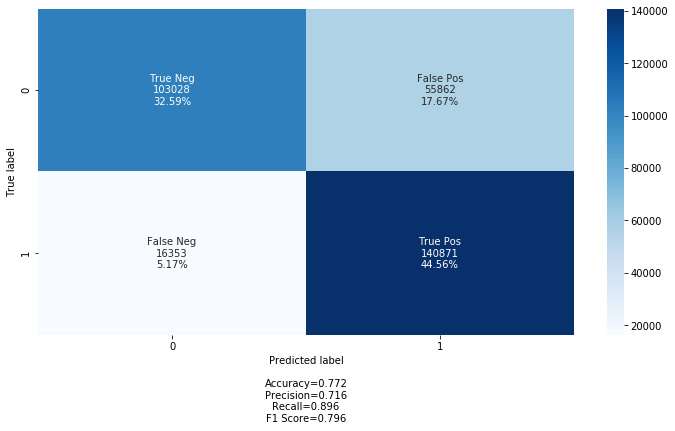

In [16]:
cf_matrix = confusion_matrix(y_test, predicted)
labels = ["True Neg", "False Pos", "False Neg", "True Pos"]
make_confusion_matrix(cf_matrix, figsize=(12, 6), group_names=labels)

# RandomForest

In [17]:
%%time

rfc_clf = RandomForestClassifier(n_jobs=4, **base_model_params)
rfc_clf.fit(X_train, y_train)

CPU times: user 19min 23s, sys: 10.3 s, total: 19min 33s
Wall time: 4min 57s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=4,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [18]:
rfc_feature_importance = pd.DataFrame({
        "Importance": rfc_clf.feature_importances_,
        "Feature": X_train.columns
      })
rfc_feature_importance.sort_values("Importance", ascending=False, inplace=True)
rfc_feature_importance.head(10)

,Importance,Feature
118,0.330404,missing_num
120,0.327256,missing_sign
33,0.003550,f34
34,0.003504,f35
2,0.003457,f3
39,0.003387,f40
7,0.003367,f8
56,0.003259,f57
95,0.003249,f96
64,0.003241,f65


Text(0, 0.5, 'Features')

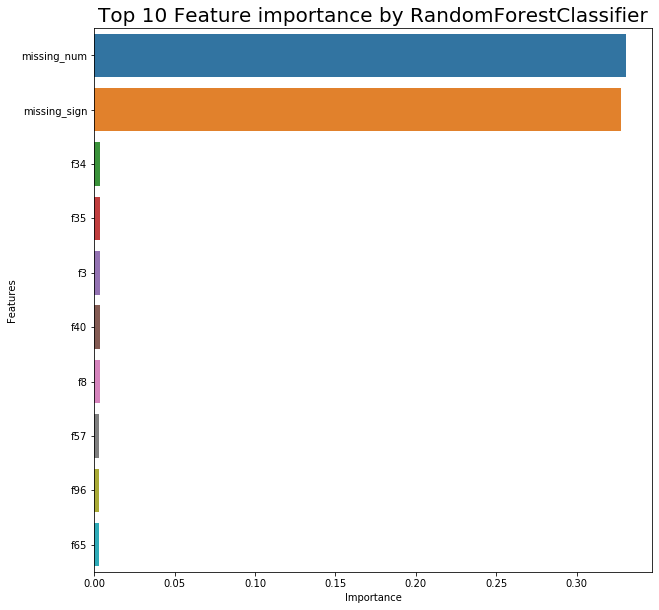

In [19]:
plt.figure(figsize=(10, 10))
feature_importance_graph = sns.barplot(y = rfc_feature_importance.Feature[:10], x = "Importance", data=rfc_feature_importance[:10], orient="h")
feature_importance_graph.set_title("Top 10 Feature importance by RandomForestClassifier", fontsize = 20)
feature_importance_graph.set_ylabel("Features")

In [20]:
y_rfc_pred = rfc_clf.predict(X_test)
accuracy_score(y_test, y_rfc_pred)

0.771443213524235

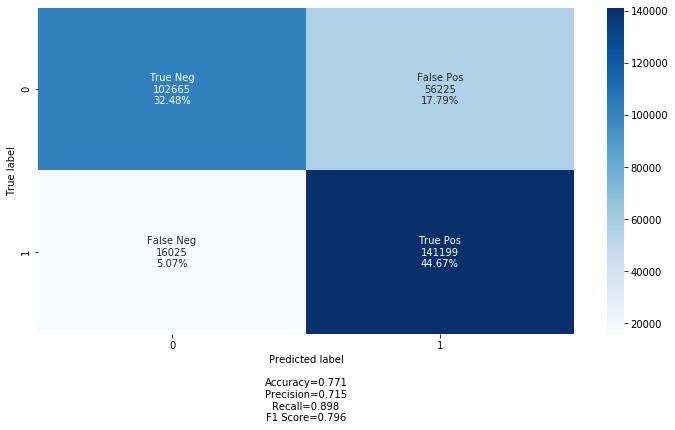

In [21]:
cf_matrix = confusion_matrix(y_test, y_rfc_pred)
labels = ["True Neg", "False Pos", "False Neg", "True Pos"]
make_confusion_matrix(cf_matrix, figsize=(12, 6), group_names=labels)

# LGBM

In [22]:
%%time

lgbc = LGBMClassifier()
lgbc.fit(X_train, y_train)

CPU times: user 2min 39s, sys: 3.35 s, total: 2min 43s
Wall time: 12.8 s


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [23]:
lgbc_feature_importance = pd.DataFrame({
        "Importance": lgbc.feature_importances_,
        "Feature": X_train.columns
      })
lgbc_feature_importance.sort_values("Importance", ascending=False, inplace=True)
lgbc_feature_importance.head(10)

,Importance,Feature
39,142,f40
118,102,missing_num
69,93,f70
46,92,f47
34,86,f35
20,81,f21
33,76,f34
44,74,f45
7,73,f8
2,66,f3


Text(0, 0.5, 'Features')

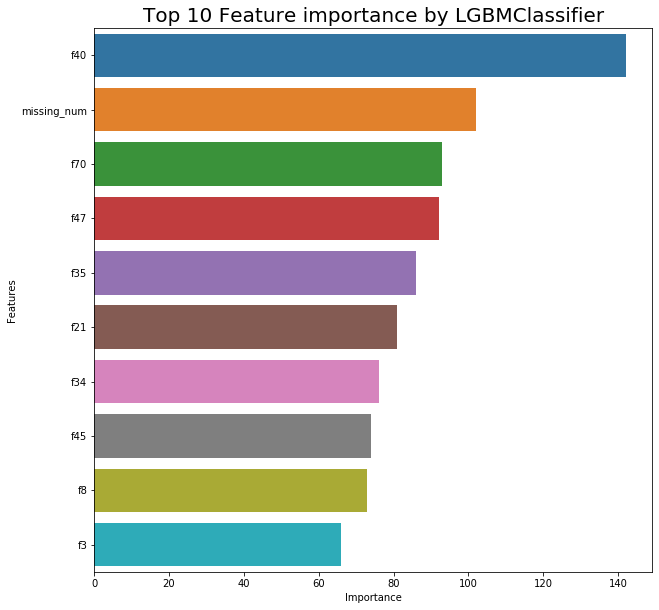

In [24]:
plt.figure(figsize=(10, 10))
feature_importance_graph = sns.barplot(y = lgbc_feature_importance.Feature[:10], x = "Importance", data=lgbc_feature_importance[:10], orient="h")
feature_importance_graph.set_title("Top 10 Feature importance by LGBMClassifier", fontsize = 20)
feature_importance_graph.set_ylabel("Features")

In [25]:
%%time

y_lgbc_pred = lgbc.predict(X_test)

CPU times: user 5.24 s, sys: 340 ms, total: 5.58 s
Wall time: 980 ms


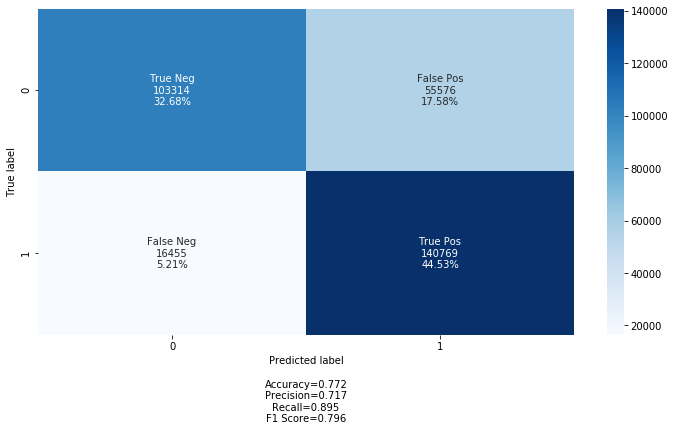

In [26]:
cf_matrix = confusion_matrix(y_test, y_lgbc_pred)
labels = ["True Neg", "False Pos", "False Neg", "True Pos"]
make_confusion_matrix(cf_matrix, figsize=(12, 6), group_names=labels)

# Sumbit

In [27]:
from datetime import datetime


def save_submission(indexes: np.array, submission: np.array, prefix: str = "", folder: str = "submissions/"):
    submit_df = pd.DataFrame({"id": indexes, "claim": submission})
    now = datetime.now()
    date_str = now.strftime("%m-%d-%Y_%H:%M:%S")
    file_name = f"{folder}{prefix}submission_{date_str}.csv"
    submit_df.to_csv(file_name, index=False)

In [28]:
df_test = pd.read_csv(f"{PATH_TO_DATA_FOLDER}test.csv", index_col="id")
print("Shape:", df_test.shape)
df_test.head()

Shape: (493474, 118)


,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,...,f109,f110,f111,f112,f113,f114,f115,f116,f117,f118
id,,,,,,,,,,,,,,,,,,,,,
957919,0.165850,0.487050,1295.00,0.02310,0.31900,0.90188,573.29,3743.7,2.705700e+12,6221.000,...,0.16253,-22.1890,2.0655,0.430880,-10.7410,81606.0,1.1940,1.980400e+14,2017.1,0.46357
957920,0.129650,0.373480,1763.00,0.72884,0.33247,-1.26310,875.55,554370.0,5.955700e+14,934.430,...,0.81528,-1.6342,1.5736,-1.071200,11.8320,90114.0,1.1507,4.388000e+16,6638.9,0.28125
957921,0.120190,0.445210,736.26,0.04615,0.29605,0.31665,2659.50,317140.0,3.977800e+14,131.810,...,0.81831,-32.7800,2.1364,-1.931200,-3.2804,37739.0,1.1548,1.718100e+14,5844.0,0.13797
957922,0.054008,0.395960,996.14,0.85934,0.36678,-0.17060,386.56,325680.0,-3.432200e+13,-26.473,...,0.86559,-2.4162,1.5199,-0.011633,1.3840,26849.0,1.1490,2.138800e+17,6173.3,0.32910
957923,0.079947,-0.006919,10574.00,0.34845,0.45008,-1.84200,3027.00,428150.0,9.291500e+11,5999.400,...,0.25190,-18.6300,3.7387,0.757080,-4.9405,50336.0,1.2488,2.151300e+17,2250.1,0.33796


In [29]:
df_test.isna().sum()

f1      7812
f2      7891
f3      7795
f4      7733
f5      7877
        ... 
f114    7942
f115    7977
f116    8083
f117    7763
f118    7885
Length: 118, dtype: int64

In [30]:
preprocess(df_test)

In [31]:
%%time

submit_my_clf = my_clf.predict(df_test)
submit_my_clf

CPU times: user 13.5 s, sys: 25.6 s, total: 39.2 s
Wall time: 1min 22s


array([1, 0, 1, ..., 1, 0, 1])

In [32]:
%%time

submit_rfc = rfc_clf.predict(df_test)
submit_rfc

CPU times: user 18.1 s, sys: 458 ms, total: 18.6 s
Wall time: 5.12 s


array([1, 0, 1, ..., 1, 0, 1])

In [33]:
%%time

submit_lgbc = lgbc.predict(df_test)
submit_lgbc

CPU times: user 7.89 s, sys: 536 ms, total: 8.43 s
Wall time: 1.52 s


array([1, 0, 1, ..., 1, 0, 1])

In [34]:
save_submission(df_test.index, submit_my_clf, prefix="my-clf_")
save_submission(df_test.index, submit_rfc, prefix="rfc_")
save_submission(df_test.index, submit_lgbc, prefix="lgbc_")

# Bagging

In [35]:
def bagging_result(predicts: List[np.ndarray]) -> np.array:
    res = 0.0
    for i in predicts:
        res += i
    res /= len(predicts)
    ans = res.argmax(axis=1)
    return ans

## Bagging ckeck metrics

In [36]:
%time

proba_test_my_clf = my_clf.predict_proba(X_test)
proba_test_rfc = rfc_clf.predict_proba(X_test)
proba_test_lgbc = lgbc.predict_proba(X_test)

y_begg_pred = bagging_result([proba_test_my_clf, proba_test_rfc, proba_test_lgbc])

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.01 µs


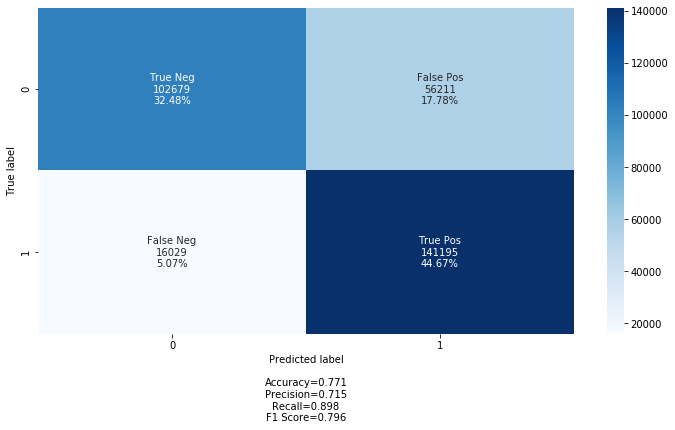

In [37]:
cf_matrix = confusion_matrix(y_test, y_begg_pred)
labels = ["True Neg", "False Pos", "False Neg", "True Pos"]
make_confusion_matrix(cf_matrix, figsize=(12, 6), group_names=labels)

In [38]:
%time

proba_my_clf = my_clf.predict_proba(df_test)
proba_rfc = rfc_clf.predict_proba(df_test)
proba_lgbc = lgbc.predict_proba(df_test)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 4.77 µs


In [39]:
begg_res = bagging_result([proba_my_clf, proba_rfc, proba_lgbc])
begg_res

array([1, 0, 1, ..., 1, 0, 1])

In [40]:
diff_answer = (begg_res != submit_lgbc).sum()
diff_percent = round(diff_answer / submit_rfc.shape[0] * 100.0, 2)
print(f"Diff answer {diff_percent}%: {diff_answer}/{submit_rfc.shape[0]}")

Diff answer 0.33%: 1637/493474


In [41]:
save_submission(df_test.index, begg_res, prefix="bagging_")

# Best my model is LGBMClassifier by leaderboard